In [1]:
library(tidyverse)
library(cowplot)
library(scales)
library(RColorBrewer)
library(here)
library(lemon)
library(magick)

suppressPackageStartupMessages({
    library(phangorn)
    library(ggtree)
    library(treeio)
})

devtools::load_all(".")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

here() starts at /mnt/expressions/mp/archaic-ychr

Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%

Loading ychr


# Figure 1

In [2]:
ages <- tribble(
    ~"name", ~"age_low", ~"age_high",
    "Mezmaiskaya 2", 42960, 44600,
    "Spy 94a", 37880, 39150,
    "El Sidrón 1253", 43700, 44300,
    "Denisova 4", 55200, 84100,
    "Denisova 8", 105600, 136400
) %>% assign_set

In [3]:
# this also loads a "colors" vector from phylogeny.ipynb!
load(here("data/rds/phylogeny.RData"))

In [4]:
kya <- function (x) {
    number_format(
        accuracy = 1,
        scale = 1/1000,
#        suffix = " kya",
        big.mark = ",")(x)
}

In [5]:
label_colors <- hue_pal()(3)[2:3]

In [6]:
p_ages <- ages %>%
mutate(age_mean = (age_high + age_low) / 2) %>%
ggplot(aes(fct_reorder(name, age_mean), age_mean, color = set)) +
    geom_linerange(size = 1.5, aes(ymin = age_low, ymax = age_high)) +
    coord_flip() +
    theme_minimal() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_text(size = 11, face = "bold",
                                     color = c(rep(label_colors[2], 3), rep(label_colors[1], 2))),
          axis.text.x = element_text(size = 11),
          axis.title.x = element_text(hjust = 1.22, vjust = 5.8, margin = margin(b = -9))) +
    ylab("age [kya]") +
    guides(color = FALSE) +
    expand_limits(y = c(0, 160e3)) +
    scale_y_continuous(trans = "reverse", labels = kya, breaks = c(0, 50e3, 75e3, 100e3, 125e3, 150e3)) +
    scale_x_discrete(position = "top") +
    scale_color_manual(values = label_colors) +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.75),
                    color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.75)) +
    theme(plot.background = element_rect(fill = "white"))

p_mapages <- ggdraw() +
    draw_image(magick::image_read_pdf(here("figures/map.pdf"))) + # map of Eurasia
    draw_plot(p_ages, x = 0.58, y = 0.1, width = 0.4, height = 0.43) + # plot of ages
    geom_rect(aes(xmin = 0.58, xmax = 0.58 + 0.4, ymin = 0.1, ymax = 0.1 + 0.43),
              fill = alpha("black", 0), color = "black", size = 0.4)

In [7]:
p_coverage <- readRDS(here("data/rds/p_coverage.rds"))

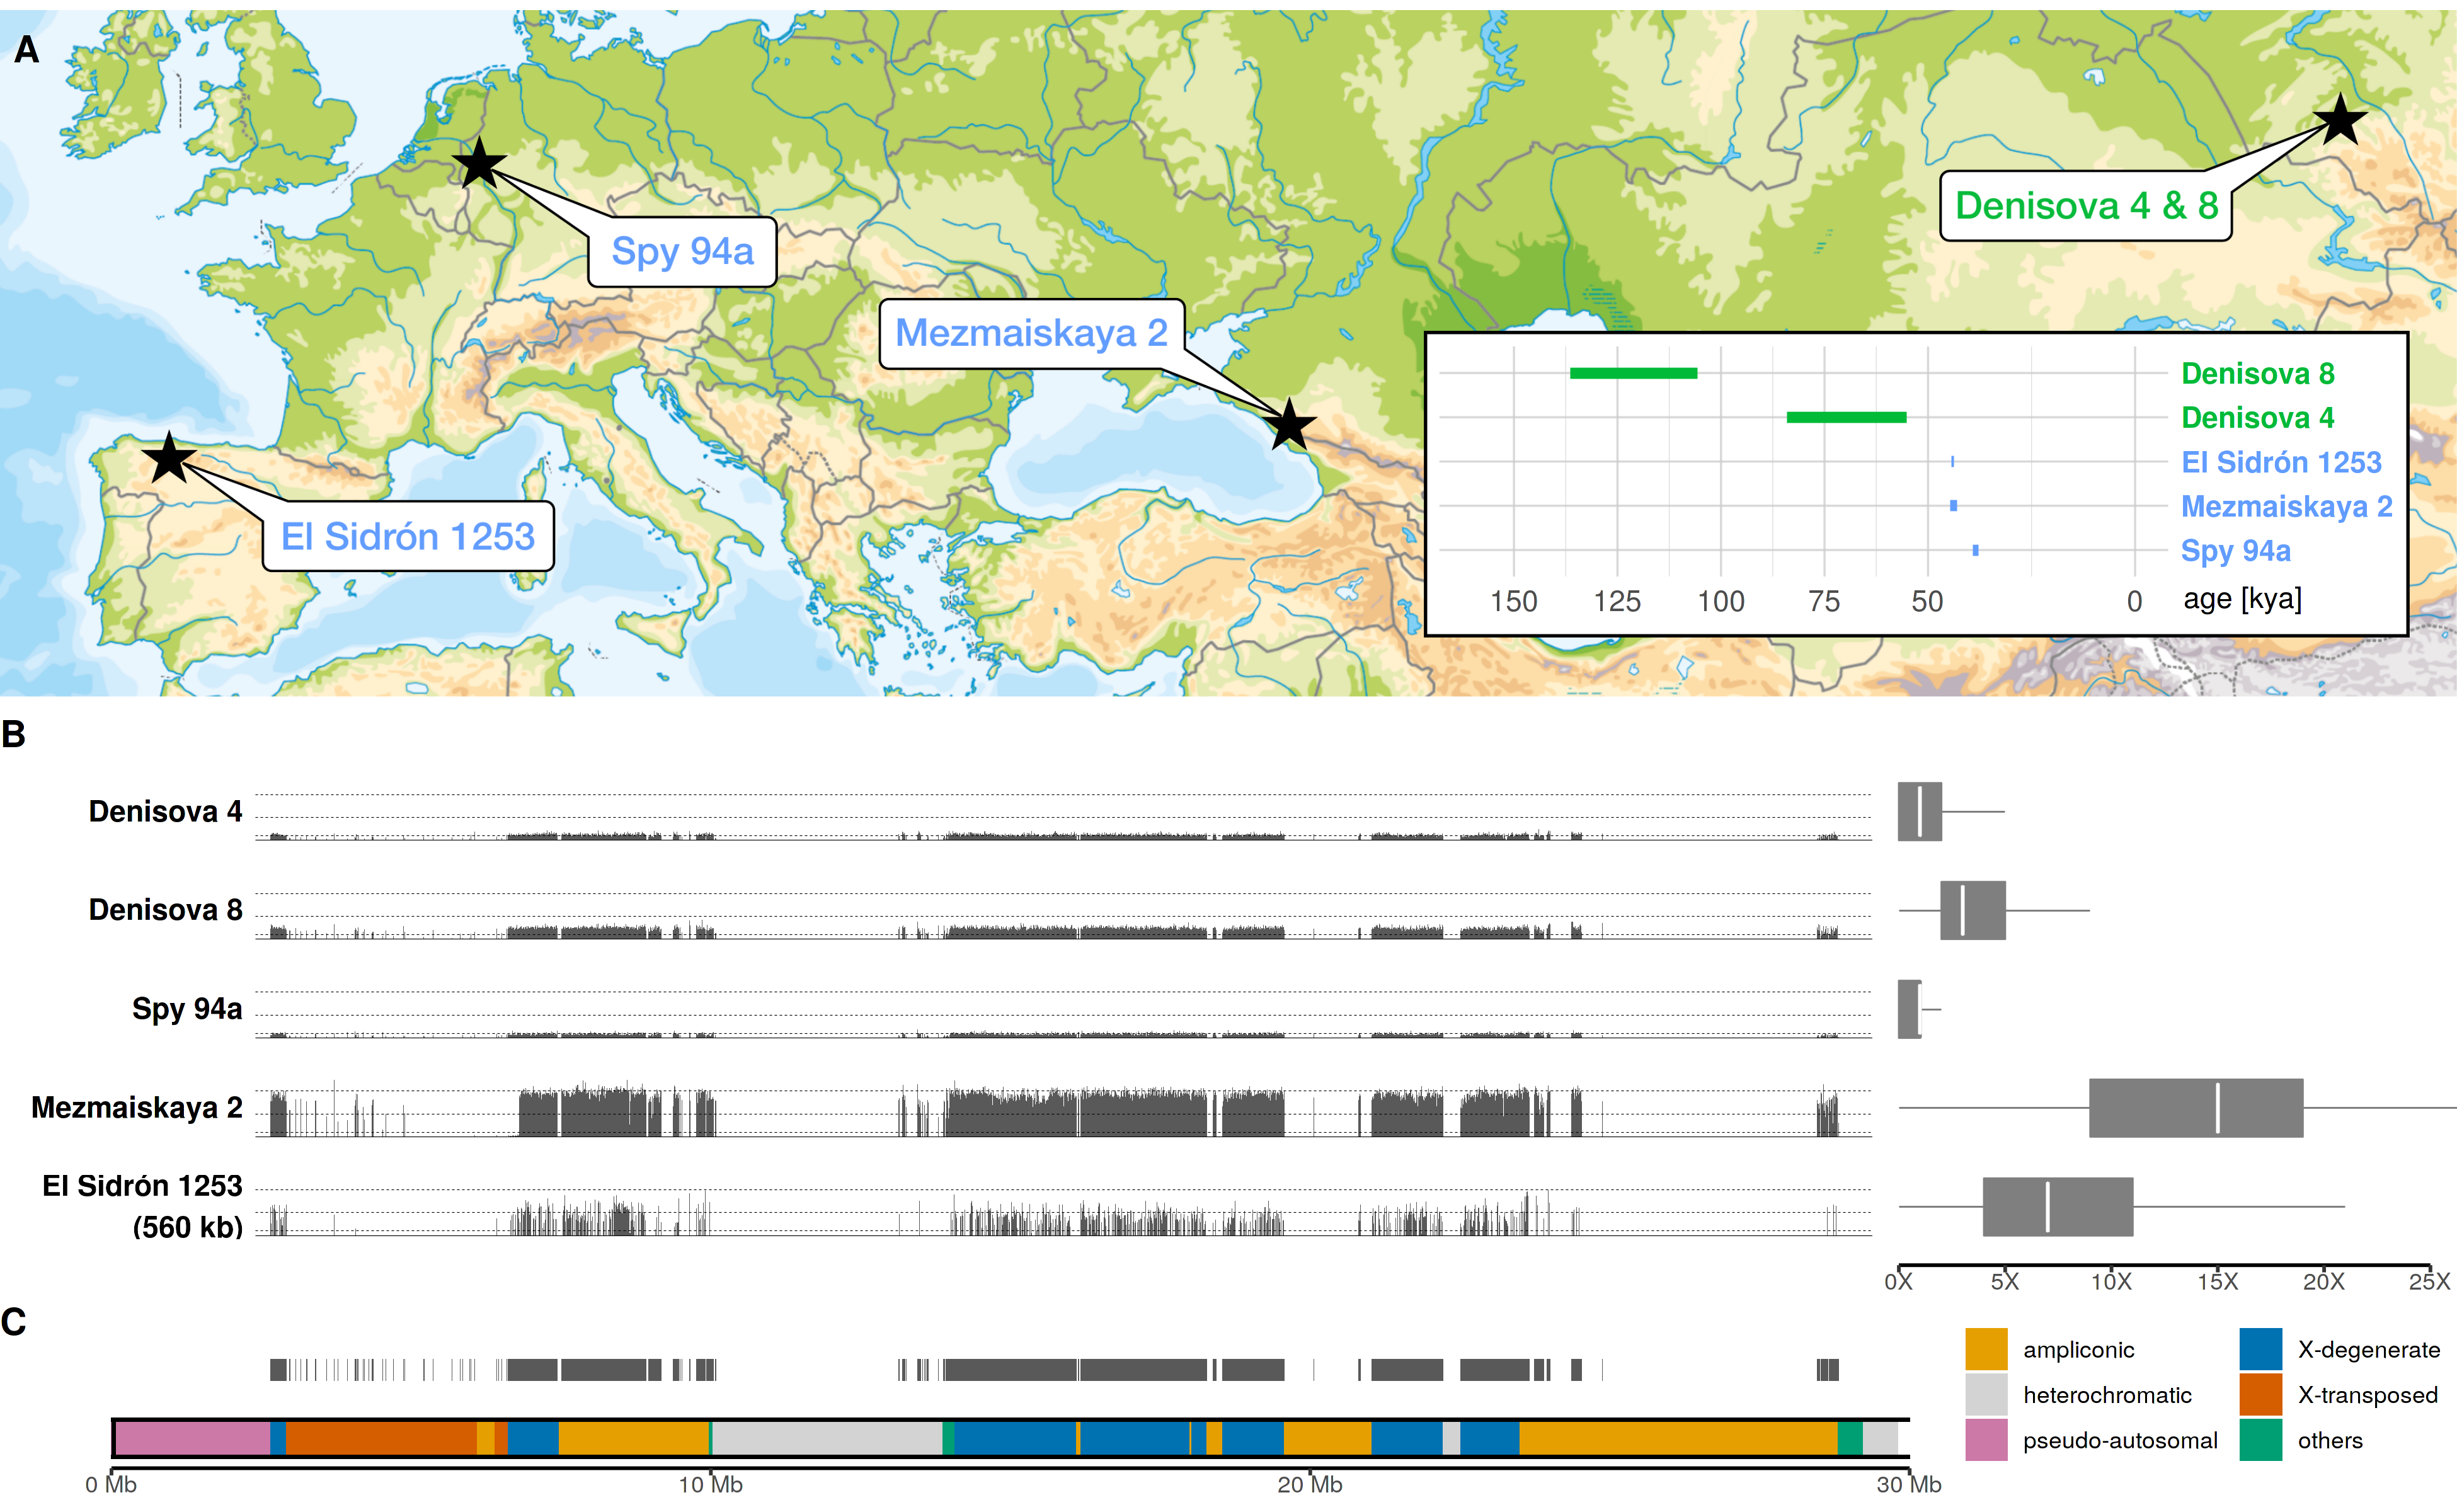

In [8]:
set_dim(13, 8)

plot_grid(
    p_mapages, p_coverage,
    nrow = 2, labels = c("A", ""),
    rel_heights = c(1, 1.14), vjust = 2.3
)

# Figure 2

In [9]:
step1 <- readRDS(here("data/rds/step1.rds"))
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

In [10]:
p_tmrca <- plot_tmrca(stat = "new", afr = "a00", mindp = 3, sites = "nodmg", filt = "filt50",
           exclude = c(paste0("mez2_dp", 1:10), "elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad",
                       "den", "den_snpad", "den4_snpad", "spy1_snpad", "den8_snpad"))

Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”

In [11]:
set_dim(6, 5)

colors <- scales::hue_pal()(3)

p_tree <- ggtree(tr, ladderize = F) +
    geom_text2(nudge_y = 0.25, nudge_x = -0.0006, aes(label = bootstrap,
               subset = node %in% c(den_node, neand_node, amh_node, amhneand_node, root_node, mezsidron_node))) +

    geom_rootedge(rootedge = root_node) +

    guides(color = F)

p_tree <- p_tree %<+% df +
    geom_tiplab(aes(color = set), offset = 0.0002, size = 5) +
    geom_point2(aes(subset = node %in% c(amhneand_node, root_node, amh_node)), size = 5,
                color = colors[c(2, 3, 1)]) +
    scale_color_manual(values = c(colors[1], colors[2], colors[3], "black")) +
    coord_capped_cart(gap = 1, x = c(-0.00045, 0.013), bottom = "both", left = "none")

p_tree <- p_tree %>% scaleClade(amh_node, 0.4) %>%
    collapse(node = nonafr_node, "max", clade_name = "non-Africans")

p_tree <- p_tree + geom_nodelab(aes(subset = node == nonafr_node), vjust = 5.7, angle = 90, size = 5)

Warning message:
“Removed 24 rows containing non-finite values (stat_root_edge).”

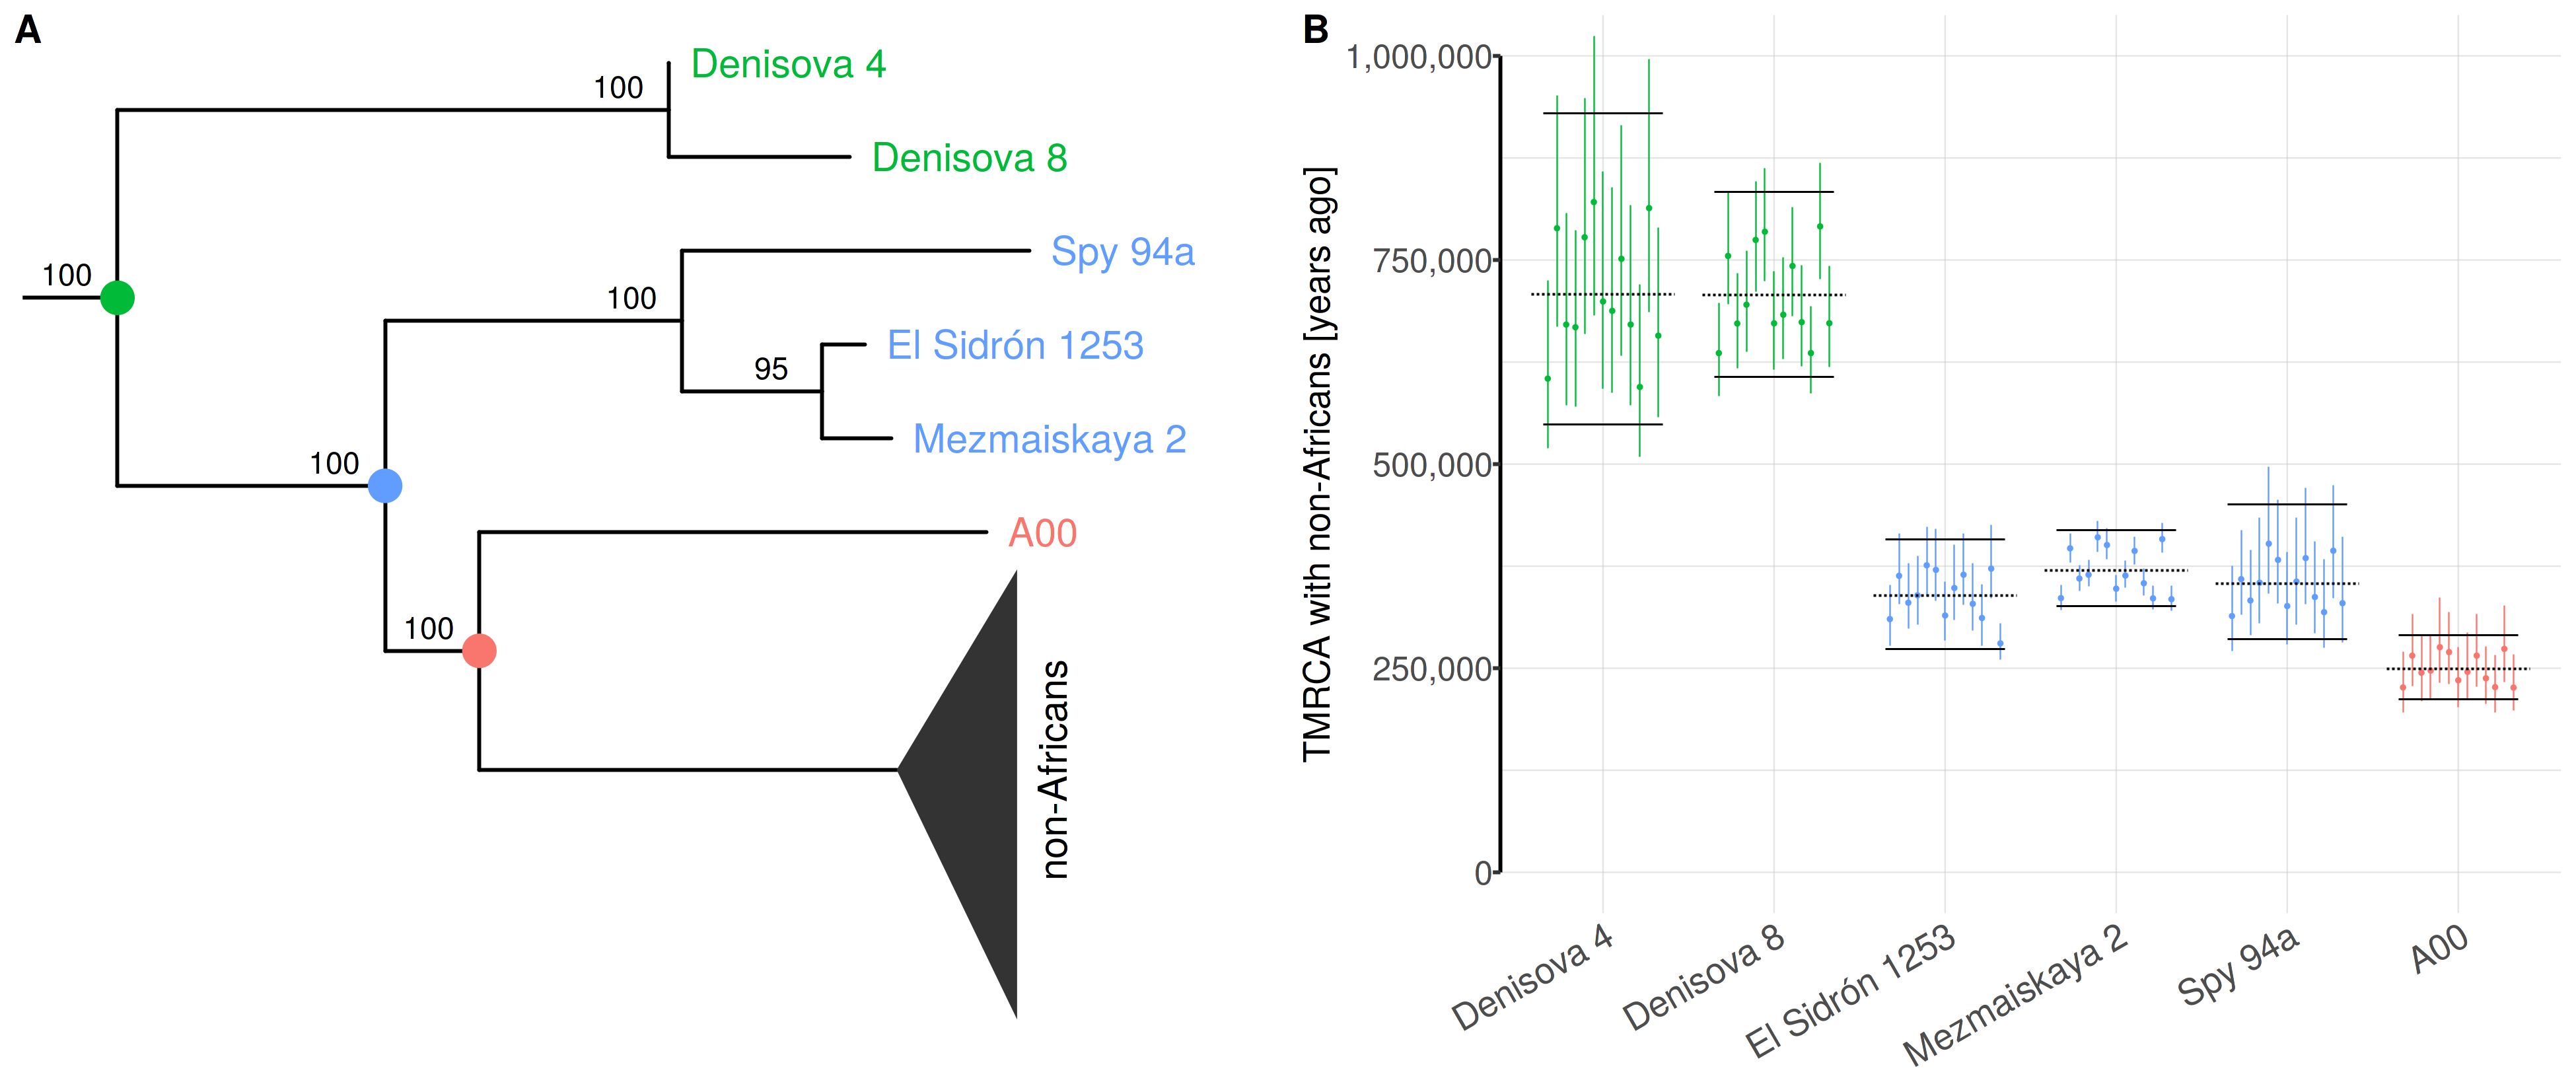

In [12]:
set_dim(13, 5.5)

plot_grid(p_tree, p_tmrca, labels = c("A", "B"))

# Figure 3

In [42]:
mean_traj_fitness <- readRDS(here("data/rds/mean_traj_fitness.rds")) %>%
    group_by(fitness_bin, gen, time) %>%
    summarise_if(is.numeric, mean) %>%
    filter(gen < 700)

Warning message:
“Removed 4256 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_hline).”

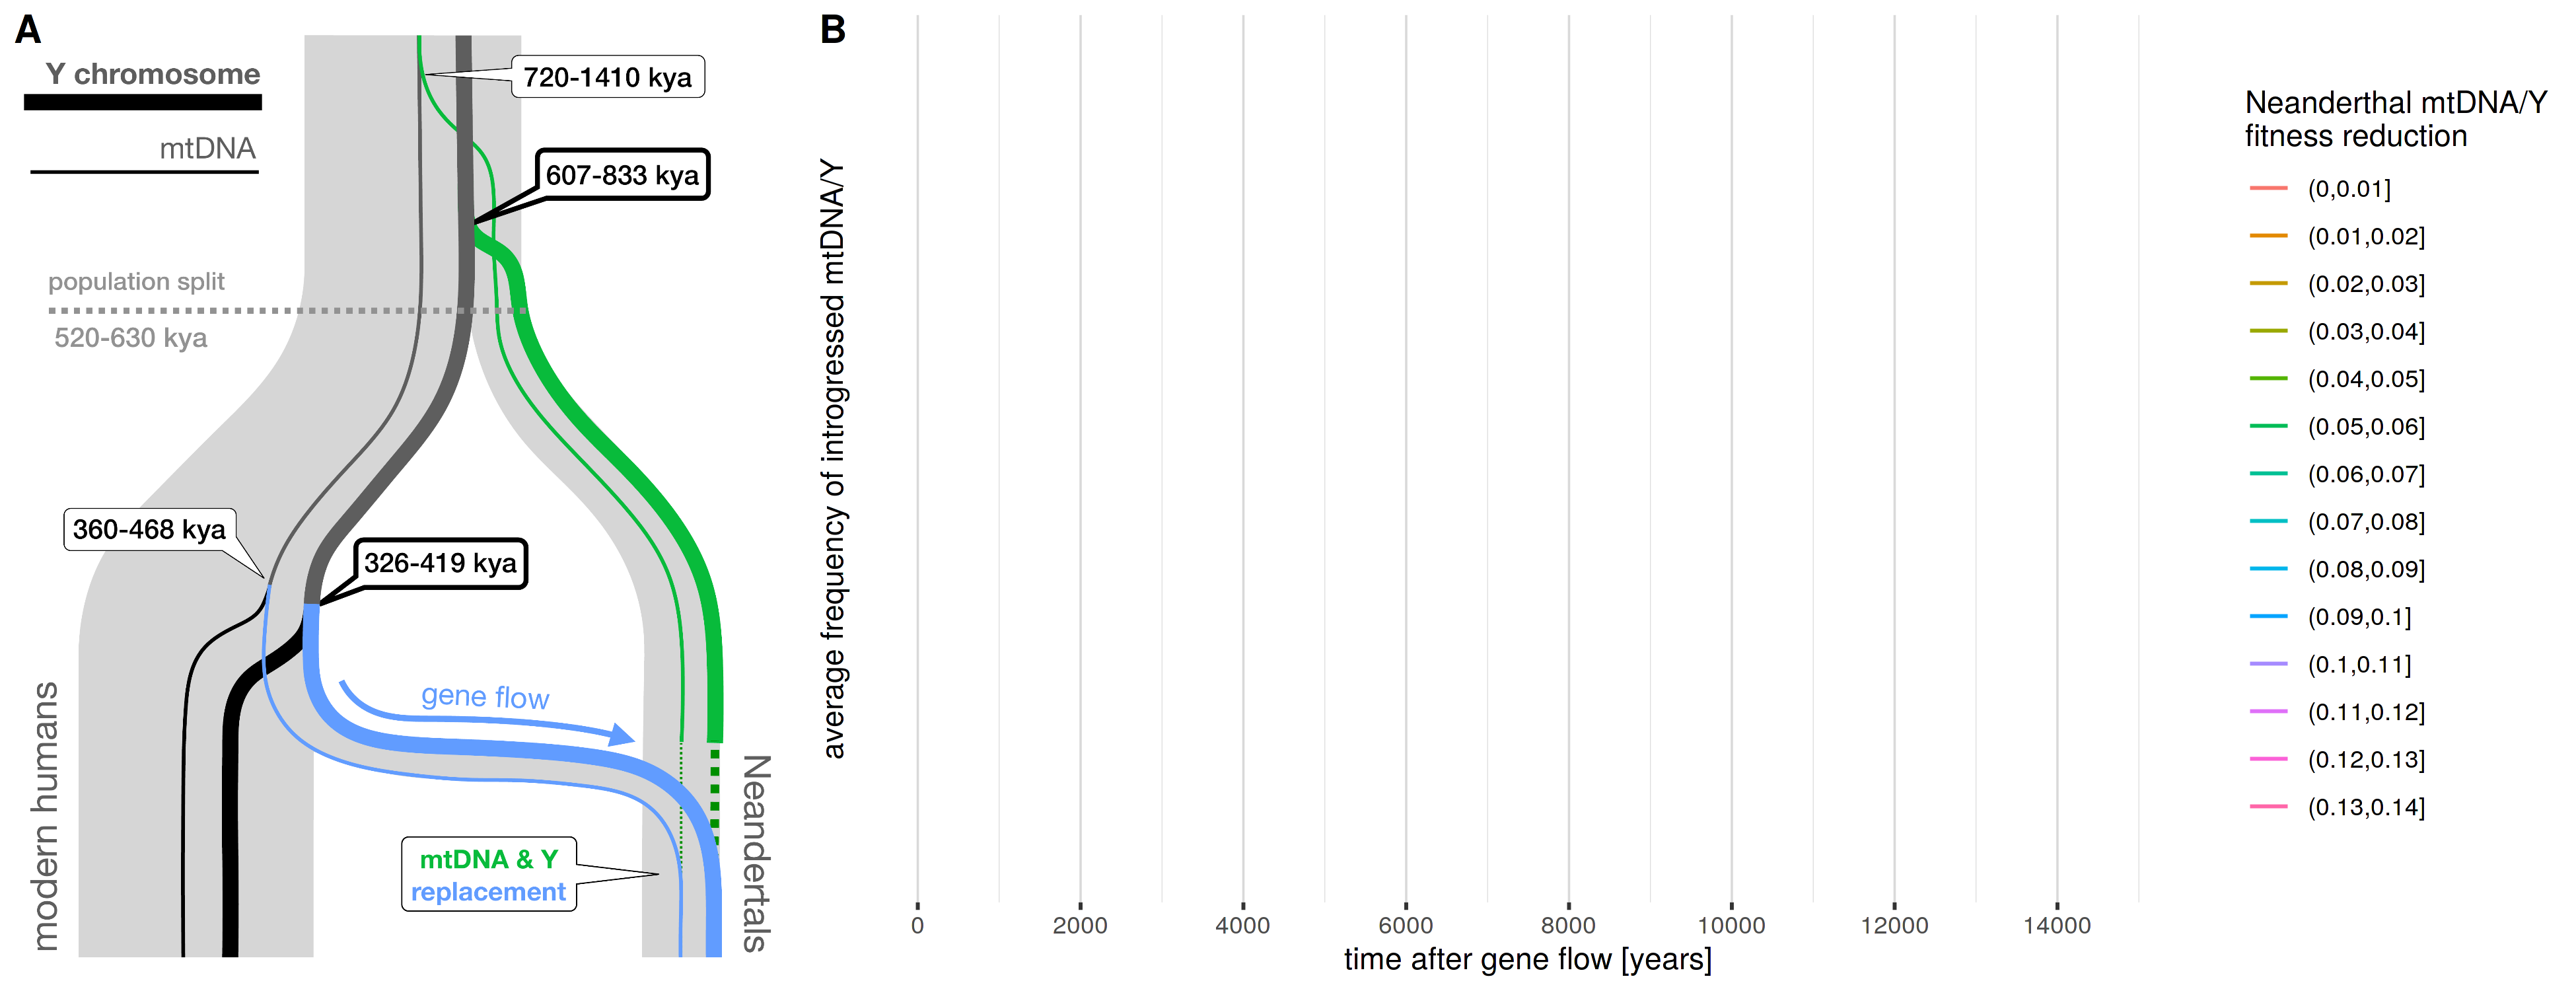

In [51]:
p_diagram <- ggdraw() + draw_image(magick::image_read_pdf(here("figures/splits.pdf")))

p_traj <- mean_traj_fitness %>%
    ggplot(aes(time, ancestry, color = fitness_bin)) +
        geom_line(aes(group = interaction(gene_total, admix_time))) +
        geom_hline(yintercept = 0.05, linetype = 2) +
        labs(color = "Neanderthal mtDNA/Y\nfitness reduction",
             y = "average frequency of introgressed mtDNA/Y",
             x = "time after gene flow [years]") +
        scale_y_continuous(limits = c(0.03, 0.0), breaks = c(0, 0.05, 0.25, 0.5, 1)) +
        scale_x_continuous(breaks = seq(0, 14000, 2000)) +
    theme_classic() +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.75)) +
    theme(axis.line = element_blank())

set_dim(13, 5)

plot_grid(p_diagram, p_traj, labels = c("A", "B"), ncol = 2,
          rel_widths = c(1, 2.2))